# Applying Universal Differential Equations for Recovering Unknown Mechanism
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stevengogogo/Julia-for-SciML/doc-intro-slide?labpath=hands-on%2Flott.ipynb)

Sample code is modified from [ChrisRackauckas/universsal_differential_equations](https://github.com/ChrisRackauckas/universal_differential_equations/blob/master/LotkaVolterra/scenario_1.jl). This is the part of the work of 

> Rackauckas, Christopher, et al. "Universal differential equations for scientific machine learning." arXiv preprint arXiv:2001.04385 (2020).

## Activate the environment

In [1]:
## Environment and packages
cd(@__DIR__)
using Pkg
Pkg.activate("lotka")

  Activating project at `~/Documents/GitHub/Julia-for-SciML/hands-on/lotka`


In [2]:
Pkg.instantiate() # This step will take a while for numerous packages

┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/stevenchiu/Documents/GitHub/Julia-for-SciML/hands-on/lotka/Manifest.toml:0


## Import packages

- When importing multiple packages, this requires precompilation that takes some time.

In [4]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, ComponentArrays
using Optimization, OptimizationOptimisers, OptimizationOptimJL #OptimizationFlux for ADAM and OptimizationOptimJL for BFGS
using DiffEqSensitivity
using Lux
using Plots
gr()
using Statistics

# Set a random seed for reproduceable behaviour
using Random
rng = Random.default_rng()
Random.seed!(1234);

## Building ODE model: Ground truth model

For simplicity, we use [Lotka-Volterra system](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) as an example

\begin{align}
    \dot{x} &= \alpha x - \beta xy\\
    \dot{y} &= \gamma xy- \delta y
\end{align}

where $\alpha, \beta, \gamma$, and $\delta$ are positive real parameters

In [5]:
## Data generation
function lotka!(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α*u[1] - β*u[2]*u[1]
    du[2] = γ*u[1]*u[2]  - δ*u[2]
end

lotka! (generic function with 1 method)

In [6]:
# Define the experimental parameter
tspan = (0.0,3.0)
u0 = [0.44249296,4.6280594]
p_ = [1.3, 0.9, 0.8, 1.8]

4-element Vector{Float64}:
 1.3
 0.9
 0.8
 1.8

### Solving ODE
- `Vern7` is used for non-stiff problems. Numerous solvers can be found on [DifferentialEquations.jl's doc](https://diffeq.sciml.ai/stable/solvers/ode_solve/)
    

In [7]:
# Solve
prob = ODEProblem(lotka!, u0,tspan, p_)
solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.1)

retcode: Success
Interpolation: 1st order linear
t: 31-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 ⋮
 1.9
 2.0
 2.1
 2.2
 2.3
 2.4
 2.5
 2.6
 2.7
 2.8
 2.9
 3.0
u: 31-element Vector{Vector{Float64}}:
 [0.44249296, 4.6280594]
 [0.34212452862086234, 3.98764547181634]
 [0.2793966078254349, 3.4139529441083147]
 [0.2394952228707143, 2.9110318130603883]
 [0.21413620714095402, 2.4758280205419836]
 [0.19854852659179129, 2.1022922430734137]
 [0.18991187927524103, 1.7834096349202704]
 [0.18652973211225643, 1.5121821427640152]
 [0.18737918127509637, 1.2820806846455604]
 [0.1918587411736629, 1.087227597605956]
 [0.1996432344128222, 0.9224424008592909]
 [0.2105985019620811, 0.7832199752377471]
 [0.22473063540355143, 0.6656774980182895]
 ⋮
 [0.4333056937367298, 0.22471175932636067]
 [0.48425346211989406, 0.1947029152564331]
 [0.5425361548950363, 0.16943926722620506]
 [0.6091040110729008, 0.14819092695665834]
 [0.6850407509453579, 0.13034710141497852]
 [

## Data processing

In [8]:
# Ideal data
X = Array(solution)
t = solution.t
DX = Array(solution(solution.t, Val{1}))

full_problem = DataDrivenProblem(X, t = t, DX = DX)

# Add noise in terms of the mean
x̄ = mean(X, dims = 2)
noise_magnitude = 5e-3
Xₙ = X .+ (noise_magnitude*x̄) .* randn(eltype(X), size(X))

2×31 Matrix{Float64}:
 0.444955  0.344412  0.277873  0.246362  …  1.2542     1.41631    1.60945
 4.6231    3.98748   3.40663   2.91876      0.0810739  0.0772539  0.0672219

## Data Visualization

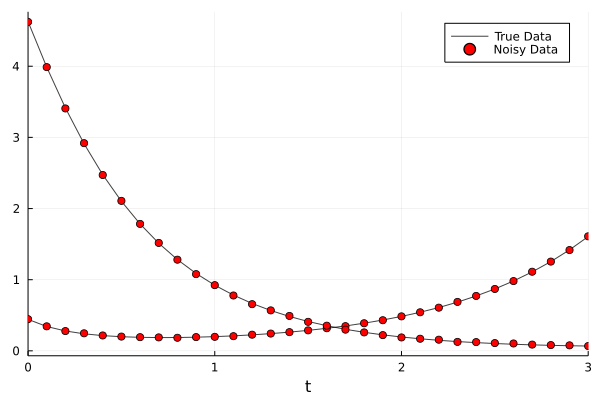

In [9]:
plot(solution, alpha = 0.75, color = :black, label = ["True Data" nothing])
scatter!(t, transpose(Xₙ), color = :red, label = ["Noisy Data" nothing])

## Build surrogate model

Suppose we only know part of the Lotka-Voltera model, and use CNN to surrogate the unknown part

\begin{align}
    \dot{x} &= \theta_1 x + U_1(\theta_3, x, y)\\ 
    \dot{y} &= -\theta_2 y + U_2(\theta_3..., x, y)
\end{align}

In [10]:
## Define the network
# Gaussian RBF as activation
rbf(x) = exp.(-(x.^2))

# Multilayer FeedForward
U = Lux.Chain(
    Lux.Dense(2,5,rbf), Lux.Dense(5,5, rbf), Lux.Dense(5,5, rbf), Lux.Dense(5,2)
)
# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, U)

# Define the hybrid model
function ude_dynamics!(du,u, p, t, p_true)
    û = U(u, p, st)[1] # Network prediction
    du[1] = p_true[1]*u[1] + û[1]
    du[2] = -p_true[4]*u[2] + û[2]
end

ude_dynamics! (generic function with 1 method)

In [11]:
# Closure with the known parameter
nn_dynamics!(du,u,p,t) = ude_dynamics!(du,u,p,t,p_)
# Define the problem (Fix: https://discourse.julialang.org/t/issue-with-ude-repository-lv-scenario-1/88618/5)
prob_nn = ODEProblem{true, SciMLBase.FullSpecialize}(nn_dynamics!,Xₙ[:, 1], tspan, p)

LoadError: UndefVarError: FullSpecialize not defined

## Training Setting

In [12]:
## Function to train the network
# Define a predictor
function predict(θ, X = Xₙ[:,1], T = t)
    _prob = remake(prob_nn, u0 = X, tspan = (T[1], T[end]), p = θ)
    Array(solve(_prob, Vern7(), saveat = T,
                abstol=1e-6, reltol=1e-6,
                sensealg = ForwardDiffSensitivity()
                ))
end

# Simple L2 loss
function loss(θ)
    X̂ = predict(θ)
    sum(abs2, Xₙ .- X̂)
end

# Container to track the losses
losses = Float64[]

callback = function (p, l)
  push!(losses, l)
  if length(losses)%50==0
      println("Current loss after $(length(losses)) iterations: $(losses[end])")
  end
  return false
end

#1 (generic function with 1 method)

## Training

The training is [splitted to two steps](https://github.com/ChrisRackauckas/universal_differential_equations/blob/7d2b21a082c517f6f2d94274376d4f1553fdebc3/LotkaVolterra/scenario_1.jl#L109-L119):
1. ADAM: for better convergence
2. BFGS: get better position

In [13]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p)->loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p))
res1 = Optimization.solve(optprob, ADAM(0.1), callback=callback, maxiters = 200)

@info "Training loss after $(length(losses)) iterations: $(losses[end])"
# Train with BFGS
@time optprob2 = Optimization.OptimizationProblem(optf, res1.minimizer)
@time res2 = Optimization.solve(optprob2, Optim.BFGS(initial_stepnorm=0.01), callback=callback, maxiters = 3000)
@info "Final training loss after $(length(losses)) iterations: $(losses[end])"

LoadError: UndefVarError: prob_nn not defined

## Visualize loss

In [14]:
# Plot the losses
pl_losses = plot(1:200, losses[1:200], yaxis = :log10, xaxis = :log10, xlabel = "Iterations", ylabel = "Loss", label = "ADAM", color = :blue)
plot!(201:length(losses), losses[201:end], yaxis = :log10, xaxis = :log10, xlabel = "Iterations", ylabel = "Loss", label = "BFGS", color = :red)

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1:200]

In [15]:
# Rename the best candidate
p_trained = res2.minimizer;

LoadError: UndefVarError: res2 not defined

In [16]:
## Analysis of the trained network
# Plot the data and the approximation
ts = first(solution.t):mean(diff(solution.t))/2:last(solution.t)
X̂ = predict(p_trained, Xₙ[:,1], ts)
# Trained on noisy data vs real solution
pl_trajectory = plot(ts, transpose(X̂), xlabel = "t", ylabel ="x(t), y(t)", color = :red, label = ["UDE Approximation" nothing])
scatter!(solution.t, transpose(Xₙ), color = :black, label = ["Measurements" nothing])

# Ideal unknown interactions of the predictor
Ȳ = [-p_[2]*(X̂[1,:].*X̂[2,:])';p_[3]*(X̂[1,:].*X̂[2,:])']
# Neural network guess
Ŷ = U(X̂,p_trained,st)[1]

pl_reconstruction = plot(ts, transpose(Ŷ), xlabel = "t", ylabel ="U(x,y)", color = :red, label = ["UDE Approximation" nothing])
plot!(ts, transpose(Ȳ), color = :black, label = ["True Interaction" nothing])

# Plot the error
pl_reconstruction_error = plot(ts, norm.(eachcol(Ȳ-Ŷ)), yaxis = :log, xlabel = "t", ylabel = "L2-Error", label = nothing, color = :red)
pl_missing = plot(pl_reconstruction, pl_reconstruction_error, layout = (2,1))

pl_overall = plot(pl_trajectory, pl_missing)
## Symbolic regression via sparse regression ( SINDy based )

LoadError: UndefVarError: p_trained not defined

## Symbolic Regression

In [17]:
# Create a Basis
@variables u[1:2]
# Generate the basis functions, multivariate polynomials up to deg 5
# and sine
b = [polynomial_basis(u, 5); sin.(u)]
basis = Basis(b,u);

# Create the thresholds which should be used in the search process
λ = exp10.(-3:0.01:5)
# Create an optimizer for the SINDy problem
opt = STLSQ(λ)

# Define different problems for the recovery
ideal_problem = DirectDataDrivenProblem(X̂, Ȳ)
nn_problem = DirectDataDrivenProblem(X̂, Ŷ)

# Test on ideal derivative data for unknown function ( not available )
println("Sparse regression")
full_res = solve(full_problem, basis, opt, maxiter = 10000, progress = true)
ideal_res = solve(ideal_problem, basis, opt, maxiter = 10000, progress = true)
nn_res = solve(nn_problem, basis, opt, maxiter = 10000, progress = true, sampler = DataSampler(Batcher(n = 4, shuffle = true)))


# Store the results
results = [full_res; ideal_res; nn_res]
# Show the results
map(println, results)
# Show the results
map(println ∘ result, results)
# Show the identified parameters
map(println ∘ parameter_map, results)

# Define the recovered, hyrid model
function recovered_dynamics!(du,u, p, t)
    û = nn_res(u, p) # Network prediction
    du[1] = p_[1]*u[1] + û[1]
    du[2] = -p_[4]*u[2] + û[2]
end


estimation_prob = ODEProblem(recovered_dynamics!, u0, tspan, parameters(nn_res))
estimate = solve(estimation_prob, Tsit5(), saveat = solution.t)

LoadError: UndefVarError: X̂ not defined

## Visualization

In [18]:
# Plot
plot(solution)
plot!(estimate)

## Simulation

# Look at long term prediction
t_long = (0.0, 50.0)
estimation_prob = ODEProblem(recovered_dynamics!, u0, t_long, parameters(nn_res))
estimate_long = solve(estimation_prob, Tsit5()) # Using higher tolerances here results in exit of julia
plot(estimate_long)

true_prob = ODEProblem(lotka!, u0, t_long, p_)
true_solution_long = solve(true_prob, Tsit5(), saveat = estimate_long.t)
plot!(true_solution_long)



## Post Processing and Plots

c1 = 3 # RGBA(174/255,192/255,201/255,1) # Maroon
c2 = :orange # RGBA(132/255,159/255,173/255,1) # Red
c3 = :blue # RGBA(255/255,90/255,0,1) # Orange
c4 = :purple # RGBA(153/255,50/255,204/255,1) # Purple

p1 = plot(t,abs.(Array(solution) .- estimate)' .+ eps(Float32),
          lw = 3, yaxis = :log, title = "Timeseries of UODE Error",
          color = [3 :orange], xlabel = "t",
          label = ["x(t)" "y(t)"],
          titlefont = "Helvetica", legendfont = "Helvetica",
          legend = :topright)

# Plot L₂
p2 = plot3d(X̂[1,:], X̂[2,:], Ŷ[2,:], lw = 3,
     title = "Neural Network Fit of U2(t)", color = c1,
     label = "Neural Network", xaxis = "x", yaxis="y",
     titlefont = "Helvetica", legendfont = "Helvetica",
     legend = :bottomright)
plot!(X̂[1,:], X̂[2,:], Ȳ[2,:], lw = 3, label = "True Missing Term", color=c2)

p3 = scatter(solution, color = [c1 c2], label = ["x data" "y data"],
             title = "Extrapolated Fit From Short Training Data",
             titlefont = "Helvetica", legendfont = "Helvetica",
             markersize = 5)

plot!(p3,true_solution_long, color = [c1 c2], linestyle = :dot, lw=5, label = ["True x(t)" "True y(t)"])
plot!(p3,estimate_long, color = [c3 c4], lw=1, label = ["Estimated x(t)" "Estimated y(t)"])
plot!(p3,[2.99,3.01],[0.0,10.0],lw=1,color=:black, label = nothing)
annotate!([(1.5,13,text("Training \nData", 10, :center, :top, :black, "Helvetica"))])
l = @layout [grid(1,2)
             grid(1,1)]
plot(p1,p2,p3,layout = l)

LoadError: UndefVarError: estimate not defined